## 1. Import Libraries

In [53]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## 2. Display Settings

In [54]:
pd.set_option("display.max_columns", None)

In [55]:
sklearn.set_config(transform_output="pandas")

In [56]:
warnings.filterwarnings("ignore")

## 3. Read the Data

In [57]:
path = r"C:\Users\Dell\OneDrive\Desktop\flight-sagemaker-project\data\train.csv"

train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-03-06,Mumbai,Hyderabad,06:00:00,09:10:00,1630,2.0,No Info,13169
1,Multiple Carriers,2019-05-18,Delhi,Cochin,13:00:00,01:30:00,750,1.0,No Info,9385
2,Jet Airways,2019-03-21,Banglore,New Delhi,11:40:00,10:25:00,1365,1.0,In-flight meal not included,7832
3,Air India,2019-05-18,Kolkata,Banglore,12:00:00,18:30:00,1830,2.0,No Info,10361
4,Goair,2019-05-03,Banglore,Delhi,07:45:00,10:40:00,175,0.0,No Info,3898
...,...,...,...,...,...,...,...,...,...,...
635,Indigo,2019-05-27,Chennai,Kolkata,07:55:00,10:15:00,140,0.0,No Info,3850
636,Jet Airways,2019-06-27,Delhi,Cochin,20:00:00,04:25:00,505,2.0,No Info,16263
637,Jet Airways,2019-06-12,Kolkata,Banglore,06:30:00,19:50:00,800,1.0,No Info,13626
638,Jet Airways,2019-06-09,Delhi,Cochin,11:00:00,14:15:00,195,0.0,No Info,9564


In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [59]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

## 4. Transformation Operations

### 4.1 airline

In [60]:
X_train.airline

0              Air India
1      Multiple Carriers
2            Jet Airways
3              Air India
4                  Goair
             ...        
635               Indigo
636          Jet Airways
637          Jet Airways
638          Jet Airways
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [61]:
air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])#.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0
636,0.0,0.0,1.0,0.0,0.0
637,0.0,0.0,1.0,0.0,0.0
638,0.0,0.0,1.0,0.0,0.0


### 4.2 date_of_journey

In [62]:
X_train.date_of_journey

0      2019-03-06
1      2019-05-18
2      2019-03-21
3      2019-05-18
4      2019-05-03
          ...    
635    2019-05-27
636    2019-06-27
637    2019-06-12
638    2019-06-09
639    2019-05-09
Name: date_of_journey, Length: 640, dtype: object

In [63]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.058824,0.333333,0.042373
1,0.666667,0.647059,0.833333,0.661017
2,0.000000,0.176471,0.500000,0.169492
3,0.666667,0.647059,0.833333,0.661017
4,0.666667,0.529412,0.666667,0.533898
...,...,...,...,...
635,0.666667,0.764706,0.000000,0.737288
636,1.000000,1.000000,0.500000,1.000000
637,1.000000,0.882353,0.333333,0.872881
638,1.000000,0.823529,1.000000,0.847458


### 4.3 source & destination

In [64]:
X_train.source

0        Mumbai
1         Delhi
2      Banglore
3       Kolkata
4      Banglore
         ...   
635     Chennai
636       Delhi
637     Kolkata
638       Delhi
639     Kolkata
Name: source, Length: 640, dtype: object

In [65]:
X_train.destination

0      Hyderabad
1         Cochin
2      New Delhi
3       Banglore
4          Delhi
         ...    
635      Kolkata
636       Cochin
637     Banglore
638       Cochin
639     Banglore
Name: destination, Length: 640, dtype: object

In [66]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Mumbai,Hyderabad
1,Delhi,Cochin
2,Banglore,New Delhi
3,Kolkata,Banglore
4,Banglore,Delhi
...,...,...
635,Chennai,Kolkata
636,Delhi,Cochin
637,Kolkata,Banglore
638,Delhi,Cochin


In [67]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-1.769133,-0.936490
1,1.005879,1.005299
2,-1.120517,-0.936490
3,-0.011761,-0.051299
4,-1.120517,-1.795901
...,...,...
635,-1.769133,-0.936490
636,1.005879,1.005299
637,-0.011761,-0.051299
638,1.005879,1.005299


In [68]:
np.union1d(
	X_train.source.unique(),
	X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [69]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,0,1
3,1,0
4,0,1
...,...,...
635,0,1
636,1,0
637,1,0
638,1,0


In [70]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-1.769133,-0.936490,1,0
1,1.005879,1.005299,1,0
2,-1.120517,-0.936490,0,1
3,-0.011761,-0.051299,1,0
4,-1.120517,-1.795901,0,1
...,...,...,...,...
635,-1.769133,-0.936490,0,1
636,1.005879,1.005299,1,0
637,-0.011761,-0.051299,1,0
638,1.005879,1.005299,1,0


### 4.4 dep_time & arrival_time

In [71]:
X_train.dep_time

0      06:00:00
1      13:00:00
2      11:40:00
3      12:00:00
4      07:45:00
         ...   
635    07:55:00
636    20:00:00
637    06:30:00
638    11:00:00
639    20:00:00
Name: dep_time, Length: 640, dtype: object

In [72]:
X_train.arrival_time

0      09:10:00
1      01:30:00
2      10:25:00
3      18:30:00
4      10:40:00
         ...   
635    10:15:00
636    04:25:00
637    19:50:00
638    14:15:00
639    10:05:00
Name: arrival_time, Length: 640, dtype: object

In [73]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,06:00:00,09:10:00
1,13:00:00,01:30:00
2,11:40:00,10:25:00
3,12:00:00,18:30:00
4,07:45:00,10:40:00
...,...,...
635,07:55:00,10:15:00
636,20:00:00,04:25:00
637,06:30:00,19:50:00
638,11:00:00,14:15:00


In [74]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.260870,0.000000,0.391304,0.181818
1,0.565217,0.000000,0.043478,0.545455
2,0.478261,0.727273,0.434783,0.454545
3,0.521739,0.000000,0.782609,0.545455
4,0.304348,0.818182,0.434783,0.727273
...,...,...,...,...
635,0.304348,1.000000,0.434783,0.272727
636,0.869565,0.000000,0.173913,0.454545
637,0.260870,0.545455,0.826087,0.909091
638,0.478261,0.000000,0.608696,0.272727


In [75]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,morning
1,afternoon,night
2,morning,morning
3,afternoon,evening
4,morning,morning
...,...,...
635,morning,morning
636,night,morning
637,morning,evening
638,morning,afternoon


In [76]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.67
1,0.000000,1.00
2,1.000000,0.67
3,0.000000,0.57
4,1.000000,0.67
...,...,...
635,1.000000,0.67
636,0.164948,0.67
637,1.000000,0.57
638,1.000000,0.00


In [77]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.260870,0.000000,0.391304,0.181818,1.000000,0.67
1,0.565217,0.000000,0.043478,0.545455,0.000000,1.00
2,0.478261,0.727273,0.434783,0.454545,1.000000,0.67
3,0.521739,0.000000,0.782609,0.545455,0.000000,0.57
4,0.304348,0.818182,0.434783,0.727273,1.000000,0.67
...,...,...,...,...,...,...
635,0.304348,1.000000,0.434783,0.272727,1.000000,0.67
636,0.869565,0.000000,0.173913,0.454545,0.164948,0.67
637,0.260870,0.545455,0.826087,0.909091,1.000000,0.57
638,0.478261,0.000000,0.608696,0.272727,1.000000,0.00


### 4.5 duration

In [78]:
X_train.duration

0      1630
1       750
2      1365
3      1830
4       175
       ... 
635     140
636     505
637     800
638     195
639     845
Name: duration, Length: 640, dtype: int64

In [79]:
(
	X_train
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
	# .shape
)

array([[175.],
       [515.],
       [910.]])

In [80]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [81]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.0,0.0,0.904837,0.904837
1,0.0,0.0,1.000000,1.000000
2,0.0,0.0,1.000000,1.000000
3,0.0,0.0,0.904837,0.904837
4,0.0,0.0,0.904837,0.904837
...,...,...,...,...
635,0.0,0.0,0.904837,0.904837
636,0.0,0.0,0.904837,0.904837
637,0.0,0.0,1.000000,1.000000
638,0.0,0.0,0.904837,0.904837


In [82]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [83]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [84]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.374390,-0.126897,-0.089882,2.0,1,1.970684
1,-0.374390,-0.126897,-0.089882,2.0,0,0.217305
2,-0.374390,-0.126897,-0.089882,2.0,1,1.442678
3,-0.374390,-0.126897,-0.089882,2.0,1,2.369180
4,2.987867,-0.126897,-0.089882,0.0,0,-0.928370
...,...,...,...,...,...,...
635,-0.374390,-0.126897,-0.089882,0.0,0,-0.998106
636,-0.374390,-0.011605,-0.089882,2.0,0,-0.270852
637,-0.374390,-0.126897,-0.089882,2.0,0,0.316928
638,-0.374390,-0.126897,-0.089882,1.0,0,-0.888520


### 4.6 total_stops

In [85]:
X_train.total_stops

0      2.0
1      1.0
2      1.0
3      2.0
4      0.0
      ... 
635    0.0
636    2.0
637    1.0
638    0.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [86]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,2.0,0
1,1.0,0
2,1.0,0
3,2.0,0
4,0.0,1
...,...,...
635,0.0,1
636,2.0,0
637,1.0,0
638,0.0,1


### 4.7 additional_info

In [87]:
X_train.additional_info

0                          No Info
1                          No Info
2      In-flight meal not included
3                          No Info
4                          No Info
                  ...             
635                        No Info
636                        No Info
637                        No Info
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [88]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [89]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [90]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [91]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,1.0,0.0,0.0,1
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


### 4.8 Column Transformer

In [92]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,1.0,0.0,0.0,0.0,0.0,0.000000,0.058824,0.333333,0.042373,-1.769133,-0.936490,1,0,0.260870,0.000000,0.391304,0.181818,1.000000,0.67,-0.374390,-0.126897,-0.089882,2.0,1,1.970684,2.0,0,0.0,1.0,0.0,0
1,0.0,0.0,0.0,1.0,0.0,0.666667,0.647059,0.833333,0.661017,1.005879,1.005299,1,0,0.565217,0.000000,0.043478,0.545455,0.000000,1.00,-0.374390,-0.126897,-0.089882,2.0,0,0.217305,1.0,0,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,-1.120517,-0.936490,0,1,0.478261,0.727273,0.434783,0.454545,1.000000,0.67,-0.374390,-0.126897,-0.089882,2.0,1,1.442678,1.0,0,1.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,-0.011761,-0.051299,1,0,0.521739,0.000000,0.782609,0.545455,0.000000,0.57,-0.374390,-0.126897,-0.089882,2.0,1,2.369180,2.0,0,0.0,1.0,0.0,0
4,0.0,0.0,0.0,0.0,1.0,0.666667,0.529412,0.666667,0.533898,-1.120517,-1.795901,0,1,0.304348,0.818182,0.434783,0.727273,1.000000,0.67,2.987867,-0.126897,-0.089882,0.0,0,-0.928370,0.0,1,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0,0.666667,0.764706,0.000000,0.737288,-1.769133,-0.936490,0,1,0.304348,1.000000,0.434783,0.272727,1.000000,0.67,-0.374390,-0.126897,-0.089882,0.0,0,-0.998106,0.0,1,0.0,1.0,0.0,0
636,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,0.500000,1.000000,1.005879,1.005299,1,0,0.869565,0.000000,0.173913,0.454545,0.164948,0.67,-0.374390,-0.011605,-0.089882,2.0,0,-0.270852,2.0,0,0.0,1.0,0.0,0
637,0.0,0.0,1.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,-0.011761,-0.051299,1,0,0.260870,0.545455,0.826087,0.909091,1.000000,0.57,-0.374390,-0.126897,-0.089882,2.0,0,0.316928,1.0,0,0.0,1.0,0.0,0
638,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,1.000000,0.847458,1.005879,1.005299,1,0,0.478261,0.000000,0.608696,0.272727,1.000000,0.00,-0.374390,-0.126897,-0.089882,1.0,0,-0.888520,0.0,1,0.0,1.0,0.0,0


## 5. Feature Selection

In [93]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 6. Putting it all Together

In [94]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.0,0.042373,-1.769133,-0.936490,-0.374390,2.0,1,1.970684,2.0,0
1,0.0,0.0,0.0,0.661017,1.005879,1.005299,-0.374390,2.0,0,0.217305,1.0,0
2,0.0,1.0,0.0,0.169492,-1.120517,-0.936490,-0.374390,2.0,1,1.442678,1.0,0
3,0.0,0.0,0.0,0.661017,-0.011761,-0.051299,-0.374390,2.0,1,2.369180,2.0,0
4,0.0,0.0,1.0,0.533898,-1.120517,-1.795901,2.987867,0.0,0,-0.928370,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
635,1.0,0.0,0.0,0.737288,-1.769133,-0.936490,-0.374390,0.0,0,-0.998106,0.0,1
636,0.0,1.0,0.0,1.000000,1.005879,1.005299,-0.374390,2.0,0,-0.270852,2.0,0
637,0.0,1.0,0.0,0.872881,-0.011761,-0.051299,-0.374390,2.0,0,0.316928,1.0,0
638,0.0,1.0,0.0,0.847458,1.005879,1.005299,-0.374390,1.0,0,-0.888520,0.0,1


## 7. Visualizations

In [95]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 5.386555321111134e-05,
 'air__airline_Indigo': 0.13801509867410625,
 'air__airline_Jet Airways': 0.16614696868493725,
 'air__airline_Multiple Carriers': 0.02086454405256377,
 'air__airline_Other': 0.12794838392661215,
 'doj__date_of_journey_month': 0.00547303468466868,
 'doj__date_of_journey_week': 0.09189578264618033,
 'doj__date_of_journey_day_of_week': 0.0009689778434669449,
 'doj__date_of_journey_day_of_year': 0.1801468306315311,
 'location__source': 0.1427989939887309,
 'location__destination': 0.14897106686144465,
 'location__source_is_north': 0.07313293403573602,
 'location__destination_is_north': 0.07313293403573602,
 'time__dep_time_hour': -0.0026464193067448813,
 'time__dep_time_minute': 0.03360526004699268,
 'time__arrival_time_hour': 0.05124942261126856,
 'time__arrival_time_minute': 0.025512820180974893,
 'time__dep_time_part_of_day': 0.0007314392292825748,
 'time__arrival_time_part_of_day': 0.018125317809123742,
 'dur__duration_rbf_25': 0.148761

In [96]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'dur__duration_rbf_75': -0.004374952821230904,
 'info__additional_info_No Info': -0.004072288057000328,
 'info__additional_info': -0.004072288057000328,
 'dur__duration_rbf_50': -0.0038726704791816426,
 'time__dep_time_hour': -0.0026464193067448813,
 'info__additional_info_In-flight meal not included': -0.0009948176051427133,
 'air__airline_Air India': 5.386555321111134e-05,
 'time__dep_time_part_of_day': 0.0007314392292825748,
 'doj__date_of_journey_day_of_week': 0.0009689778434669449,
 'doj__date_of_journey_month': 0.00547303468466868,
 'info__additional_info_Other': 0.012391105855881138,
 'time__arrival_time_part_of_day': 0.018125317809123742,
 'air__airline_Multiple Carriers': 0.02086454405256377,
 'time__arrival_time_minute': 0.025512820180974893,
 'time__dep_time_minute': 0.03360526004699268,
 'time__arrival_time_hour': 0.05124942261126856,
 'location__source_is_north': 0.07313293403573602,
 'location__destination_is_north': 0.07313293403573602,
 'doj__date_of_journey_week': 0.0

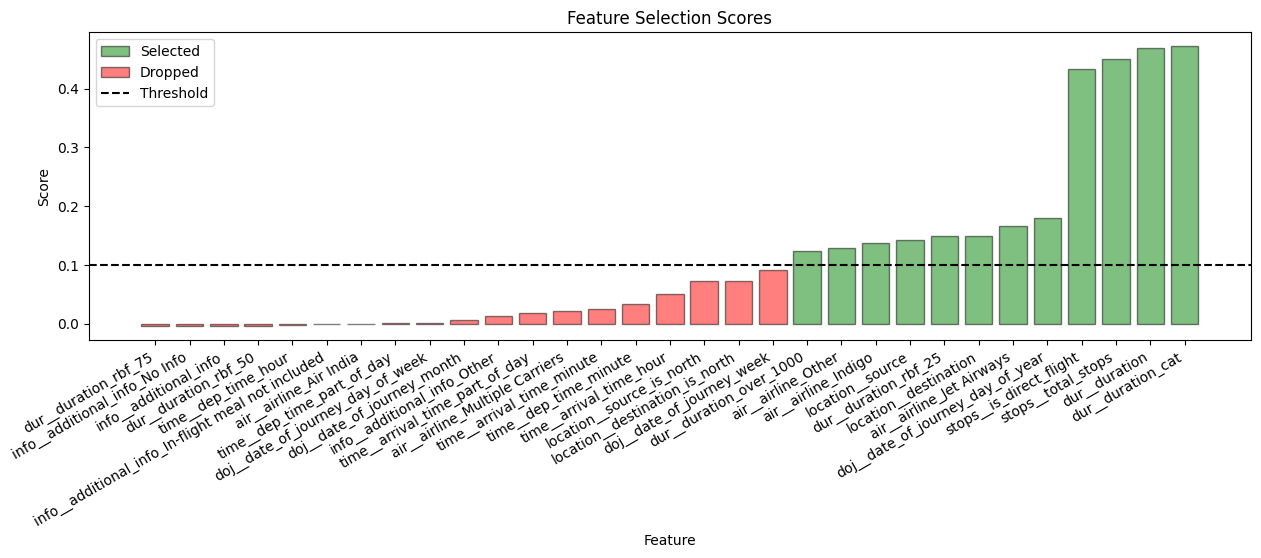

In [97]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 13 features out of that